In [1]:
import pandas as pd
import datetime
import pyxirr
from alpha_vantage.timeseries import TimeSeries
from alpha_vantage.foreignexchange import ForeignExchange
from alpha_vantage.fundamentaldata import FundamentalData

api_file = open("./api-key.txt", "r")
api_key = api_file.read()
api_file.close()

# Alpha Vantage wrapper setup
ts = TimeSeries(key=api_key, output_format='pandas', indexing_type='date')
cc = ForeignExchange(key=api_key, output_format='pandas', indexing_type='date')
fd = FundamentalData(key=api_key, output_format='pandas')

In [9]:
class Account:

    def __init__(self, currency, timeline):
        self.currency = currency
        self.name = 'CASH.' + self.currency
        self.internal_transactions = pd.Series(0, index=timeline)
        self.external_transactions = pd.Series(0, index=timeline)
    
    def internal_flow(self, date, amount):
        self.internal_transactions.at[date] = self.internal_transactions.at[date] + amount

    def external_flow(self, date, amount):
        self.external_transactions.at[date] = self.external_transactions.at[date] + amount

    def process_data(self):
        self.holdings = self.internal_transactions.cumsum()
        self.invested_capital = self.external_transactions.cumsum()


class Ticker:

    def __init__(self, name, timeline):
        self.name = name
        self.transactions = pd.Series(0, name=self.name, index=timeline)
        self.data = ts.get_daily_adjusted(self.name, outputsize='full')[0].iloc[::-1]
        self.data = self.data.reindex(index=timeline, method='nearest').fillna(method='ffill').loc[timeline[0]:timeline[-1]]
        self.prices = self.data['4. close']
        self.dividends = self.data['7. dividend amount']
        self.splits = self.data['8. split coefficient'].cumprod()
        self.overview = fd.get_company_overview(symbol='MSFT')[0]
        self.currency = self.overview['Currency']
        self.sector = self.overview['Sector']

    def update(self, date, amount):
        self.transactions.at[date] = self.transactions.at[date] + amount

    def process_data(self):
        self.holdings = self.transactions.cumsum() * self.splits
        self.holdings_value_locale = self.holdings * self.prices
        self.holdings_value = self.holdings_value_locale.rename(self.name) # / fx_rate


class Portfolio:

    def __init__(self, filename, currency):
        self.data = pd.read_csv(filename, sep=',', index_col='Date', parse_dates=True).sort_index()
        self.timeline = pd.date_range(start=self.data.index[0].date(), end=datetime.date.today())
        self.currency = currency
        self.account = Account(self.currency, self.timeline)
        self.tickers = dict() # dictionary with Ticker object at key='TICKER NAME'

    def process_data(self):
        for date, transaction in self.data.iterrows():
            self.add_transaction(date, transaction)
        self.dividend()
        self.account.process_data()
        self.join_holdings()
        self.generate_stats()

    def add_transaction(self, date, transaction):
        getattr(self, transaction.Order)(date, transaction)
    
    def deposit(self, date, transaction):
        self.account.internal_flow(date, transaction.Quantity * transaction.Price - transaction.Fee)
        self.account.external_flow(date, transaction.Quantity * transaction.Price)

    def withdrawal(self, date, transaction):
        self.account.internal_flow(date, - transaction.Quantity * transaction.Price - transaction.Fee)
        self.account.external_flow(date, - transaction.Quantity * transaction.Price)
    
    def purchase(self, date, transaction):
        self.account.internal_flow(date,- transaction.Quantity * transaction.Price - transaction.Fee ) # / fx_rate
        tick = self.tickers.setdefault(transaction.Ticker, Ticker(transaction.Ticker, self.timeline))
        tick.update(date, transaction.Quantity)

    def sale(self, date, transaction):
        self.account.internal_flow(date, transaction.Quantity * transaction.Price - transaction.Fee) # / fx_rate
        tick = self.tickers.setdefault(transaction.Ticker, Ticker(transaction.Ticker, self.timeline))
        tick.update(date, - transaction.Quantity)

    '''Not sure if this approach is better than record dividends as transactions'''
    def dividend(self):
        for ticker in self.tickers.values():
            ticker.process_data()
            self.account.internal_transactions = self.account.internal_transactions + ticker.dividends * ticker.holdings # / fx_rate

    def join_holdings(self):
        self.holdings = pd.DataFrame(self.account.holdings, columns=[self.account.name])
        for ticker in self.tickers.values():
            self.holdings = self.holdings.join(ticker.holdings_value)

    def generate_stats(self):
        self.value = self.holdings.sum(axis=1)
        self.pl = self.value - self.account.invested_capital
        self.pctpl = self.pl / self.account.invested_capital
        self.cash_flows = - self.account.external_transactions
        self.cash_flows.iloc[-1] = self.cash_flows.iloc[-1] + self.value.iloc[-1]
        self.xirr = pyxirr.xirr(self.cash_flows.index, self.cash_flows.values)
        self.xirr_ann = (1+self.xirr)**(365/len(self.timeline))-1

In [10]:
# portfolio_split = Portfolio('./samples/sample-split.csv', 'USD')
portfolio_dividend = Portfolio('./samples/sample-dividend.csv', 'USD')

In [11]:
portfolio_dividend.process_data()

<AxesSubplot:>

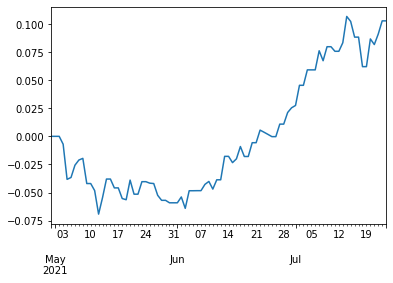

In [5]:
portfolio_dividend.pctpl.plot()

<AxesSubplot:ylabel='2021-07-24 00:00:00'>

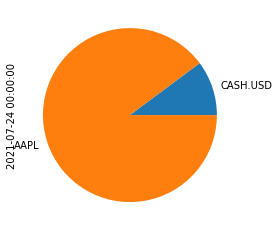

In [6]:
portfolio_dividend.holdings.iloc[-1].plot.pie()

In [12]:
portfolio_dividend.xirr, portfolio_dividend.xirr_ann

(0.5218552073041595, 4.9432823396220416)

<AxesSubplot:>

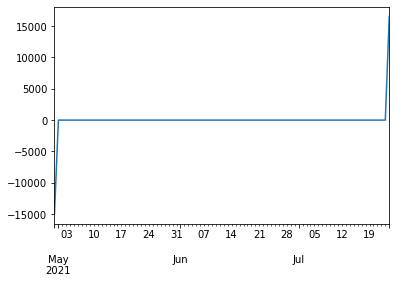

In [17]:
portfolio_dividend.cash_flows.plot()

<AxesSubplot:>

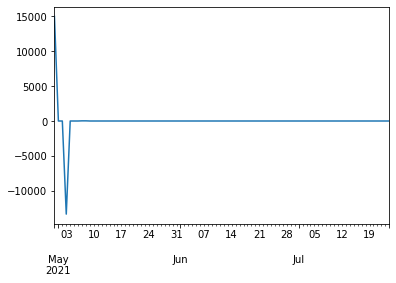

In [18]:
portfolio_dividend.account.internal_transactions.plot()